# EDA and Image preprocessing

In [1]:
import os
from pathlib import Path
from typing import Optional

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
from tqdm.notebook import tqdm_notebook

tqdm_notebook.pandas()
np.random.seed(42)
warnings.filterwarnings("ignore")

def plot_image(input_image: np.ndarray) -> None:
    """Plotting image."""
    image_shape = input_image.shape
    plt.axis("off")
    if len(image_shape) == 3:
        plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(input_image, cmap='gray')

def plot_hist(
        grayscale_image: np.ndarray,
        plot_title: Optional[str] = None,
        nbr_bins: int = 256,
        plot_cdf: bool = False,
) -> None:
    """Plotting image hist."""
    plt.figure(figsize=(10, 5))
    plt.xlim([-10, 260])
    if plot_title:
        plt.title(plot_title)

    if not plot_cdf:
        plt.hist(grayscale_image.flatten(), bins=nbr_bins, density=True)
    else:
        image_hist, bins = np.histogram(grayscale_image.flatten(), nbr_bins, [0, 255])
        cdf = image_hist.cumsum()
        norm_cdf = cdf * float(image_hist.max()) / cdf.max()
        plt.plot(norm_cdf, color='b')
        plt.hist(grayscale_image.flatten(), nbr_bins, [0, 255], color='r')
        plt.legend(("distribution function", "histogram"), loc="upper left")
    plt.grid(True)
    plt.show()

## Download data

In [2]:
sentiment_dirs = {
    "positive": "./data/source_images/positive",
    "neutral": "./data/source_images/neutral",
    "negative": "./data/source_images/negative",
}

images_filepaths_dict = {
    "positive": os.listdir(sentiment_dirs["positive"]),
    "neutral": os.listdir(sentiment_dirs["neutral"]),
    "negative": os.listdir(sentiment_dirs["negative"]),
}

print(f"Number of positive images: {len(images_filepaths_dict['positive'])}")
print(f"Number of negative images: {len(images_filepaths_dict['negative'])}")
print(f"Number of neutral images: {len(images_filepaths_dict['neutral'])}")

Number of positive images: 1324
Number of negative images: 1325
Number of neutral images: 606


In [3]:
image_info_data = {
    "file": [],
    "width": [],
    "height": [],
    "colors": [],
    "file_format": [],
    "sentiment": [],
    "source_image": [],
}

for sentiment in images_filepaths_dict.keys():
    print(f"Download images with sentiment: {sentiment}")
    for file_path in tqdm(images_filepaths_dict[sentiment]):
        dir = sentiment_dirs[sentiment]
        file, extension = os.path.splitext(file_path)
        image_info_data["file"].append(file)
        image_info_data["file_format"].append(extension)

        image = cv2.imread(os.path.join(dir, file_path))
        rows, cols, colors = image.shape

        image_info_data["source_image"].append(image)
        image_info_data["width"].append(cols)
        image_info_data["height"].append(rows)
        image_info_data["colors"].append(colors)
        image_info_data["sentiment"].append(sentiment)


image_data_df = pd.DataFrame(data=image_info_data)

Download images with sentiment: positive


100%|██████████| 1324/1324 [00:07<00:00, 185.90it/s]


Download images with sentiment: neutral


100%|██████████| 606/606 [00:03<00:00, 186.23it/s]


Download images with sentiment: negative


100%|██████████| 1325/1325 [00:07<00:00, 189.18it/s]


### Show samples

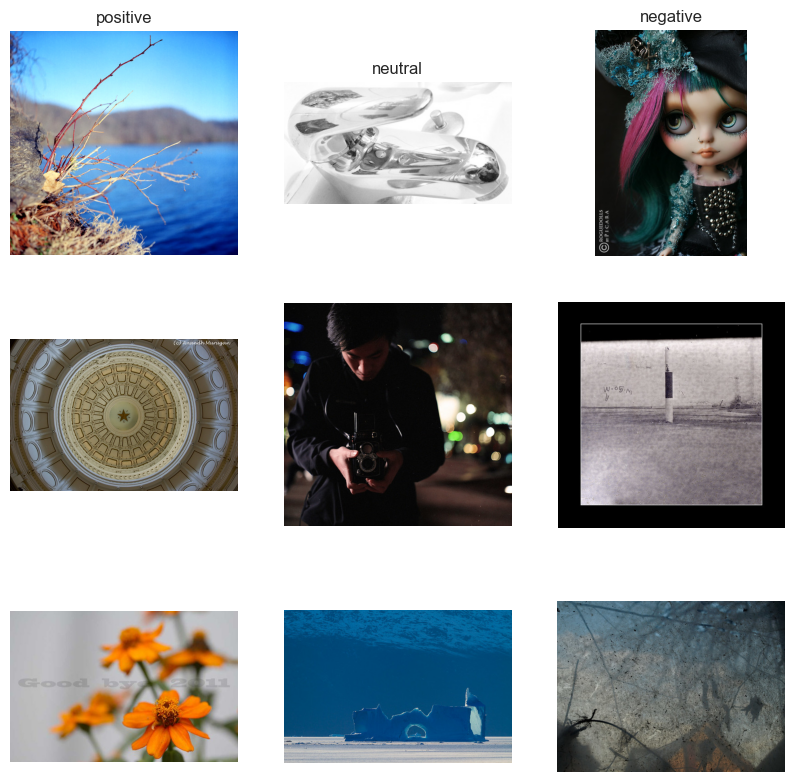

In [4]:
plt.figure(figsize = (10, 10))

sentiments = ["positive", "neutral", "negative"]

y = np.array(image_info_data["sentiment"])
X = image_data_df["source_image"].tolist()
n_samples = 3
n_classes = len(sentiments)

for i, sentiment in enumerate(sentiments):
    class_index = i
    class_indexes = np.random.choice(np.flatnonzero(y == sentiment), n_samples, replace=False)
    for i, idx in enumerate(class_indexes):
        plt_idx = i * n_classes + class_index + 1
        plt.subplot(n_samples, n_classes, plt_idx)
        plt.imshow(cv2.cvtColor(X[idx].astype('uint8'), cv2.COLOR_BGR2RGB))
        plt.axis('off')
        if i == 0:
            plt.title(sentiment)
plt.show()

## Exploratory analysis

In [5]:
image_data_without_images_df = image_data_df.drop(["source_image"], axis=1)
image_data_without_images_df.head()

file  width  height  colors file_format sentiment
0   104505632    500     333       3        .jpg  positive
1  1059249846    500     333       3        .jpg  positive
2   108501238    340     500       3        .jpg  positive
3  1089046474    500     369       3        .jpg  positive
4  1096822187    450     350       3        .jpg  positive

In [6]:
image_data_without_images_df.describe()

width       height  colors
count  3255.000000  3255.000000  3255.0
mean    466.752381   400.337942     3.0
std      63.289465    79.640669     0.0
min     143.000000   129.000000     3.0
25%     499.000000   333.000000     3.0
50%     500.000000   375.000000     3.0
75%     500.000000   500.000000     3.0
max     500.000000   500.000000     3.0

In [7]:
image_data_without_images_df.nunique()

file           3255
width           168
height          229
colors            1
file_format       1
sentiment         3
dtype: int64

<AxesSubplot: >

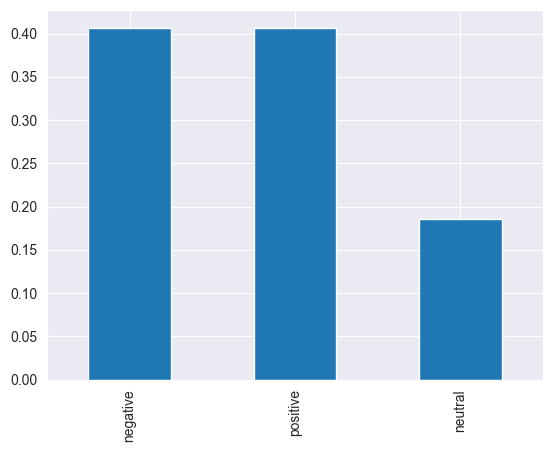

In [8]:
image_data_without_images_df["sentiment"].value_counts(normalize=True).plot(kind="bar")

In [9]:
image_data_without_images_df["file_format"].unique()

array(['.jpg'], dtype=object)

<AxesSubplot: xlabel='width', ylabel='Density'>

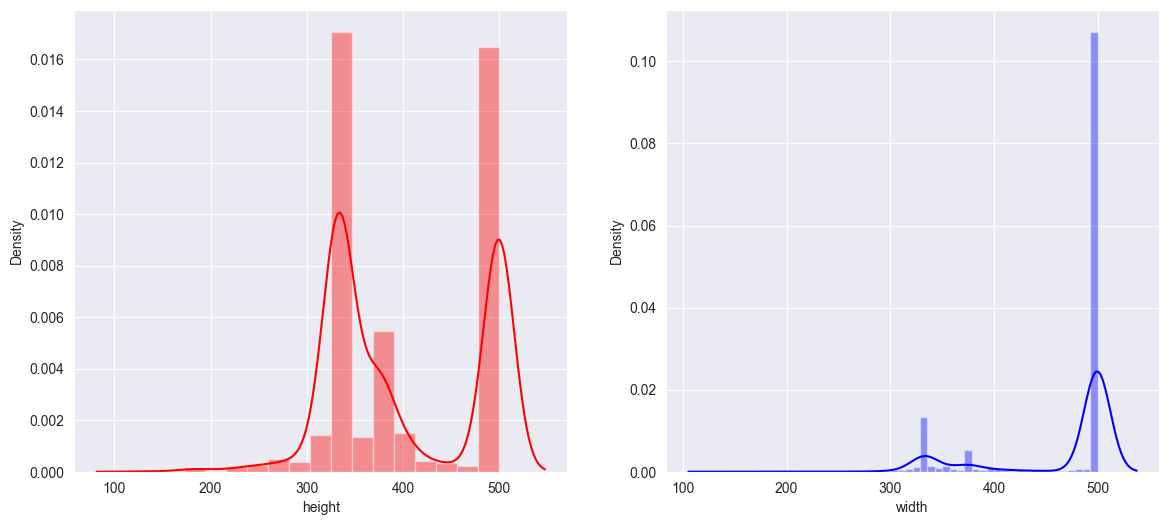

In [10]:
fig=plt.figure(figsize=(14,6))
fig.add_subplot(1,2,1)
sns.distplot(image_data_without_images_df["height"], color="red")
fig.add_subplot(1,2,2)
sns.distplot(image_data_without_images_df["width"], color="blue")

## Data preprocessing

### Resize images

In [11]:
source_images = image_data_df["source_image"].tolist()

In [12]:
def resize_image(image: np.ndarray, new_size: tuple = (500, 500)) -> np.ndarray:
    return cv2.resize(image, new_size, interpolation = cv2.INTER_AREA)


resized_images = [resize_image(image, new_size=(256, 256)) for image in tqdm(source_images)]
image_data_df["image"] = resized_images

100%|██████████| 3255/3255 [00:04<00:00, 776.80it/s]


In [13]:
np.array(resized_images).shape

(3255, 256, 256, 3)

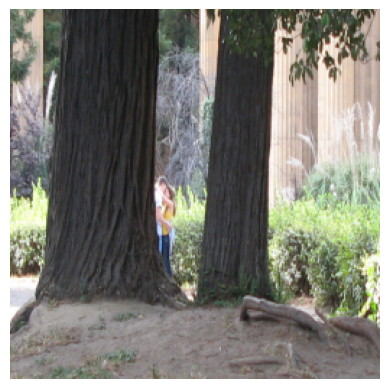

In [14]:
plot_image(resized_images[1])

In [15]:
positive_images = image_data_df[image_data_df["sentiment"] == "positive"]["image"].tolist()
negative_images = image_data_df[image_data_df["sentiment"] == "negative"]["image"].tolist()
neutral_images = image_data_df[image_data_df["sentiment"] == "neutral"]["image"].tolist()

In [16]:
grayscale_positive_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in tqdm(resized_images)]
grayscale_negative_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in tqdm(resized_images)]
grayscale_neutral_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in tqdm(resized_images)]
np.array(grayscale_positive_images).shape

100%|██████████| 3255/3255 [00:00<00:00, 20601.61it/s]


(3255, 256, 256)

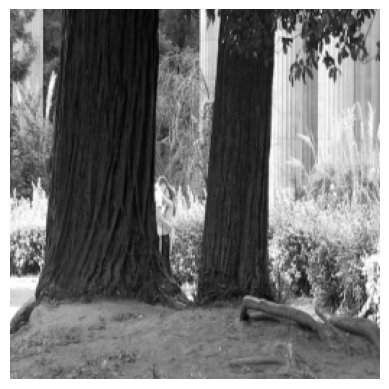

In [17]:
plot_image(grayscale_positive_images[1])

In [18]:
mean_positive_image = np.mean(grayscale_positive_images, axis=0)
mean_negative_image = np.mean(grayscale_negative_images, axis=0)
mean_neutral_image = np.mean(grayscale_neutral_images, axis=0)

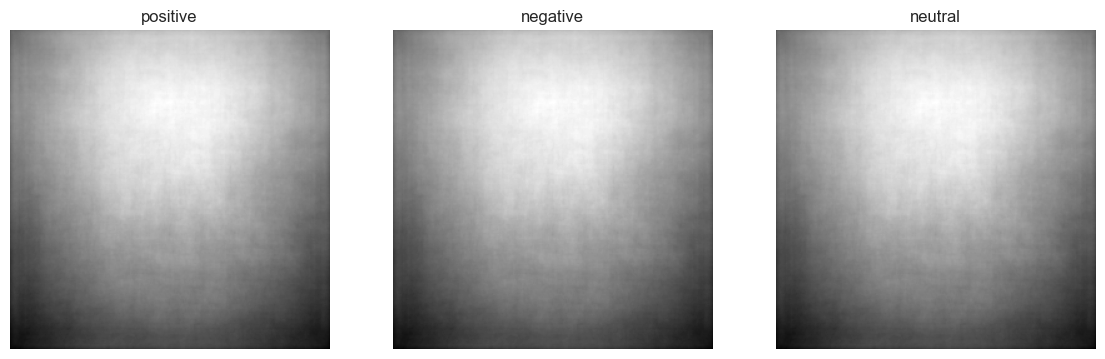

In [19]:
fig=plt.figure(figsize=(14,6))
fig.add_subplot(1,3,1)
plt.title("positive")
plot_image(mean_positive_image)
fig.add_subplot(1,3,2)
plt.title("negative")
plot_image(mean_negative_image)
fig.add_subplot(1,3,3)
plt.title("neutral")
plot_image(mean_neutral_image)

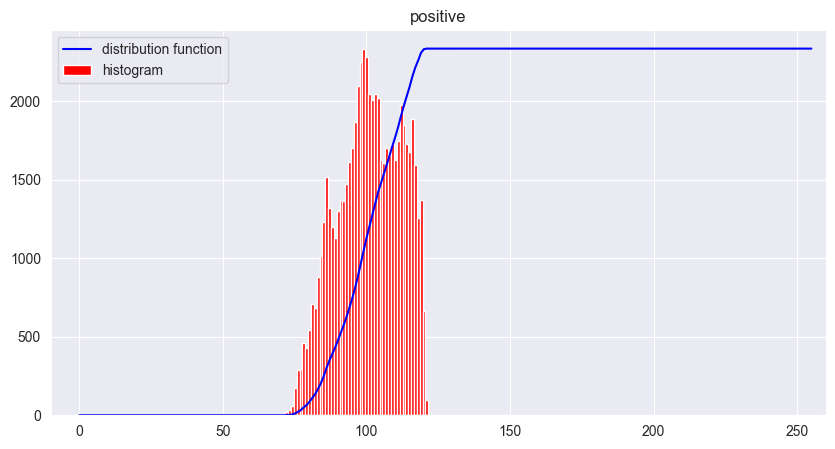

In [20]:
plot_hist(mean_positive_image, plot_title="positive", plot_cdf=True)

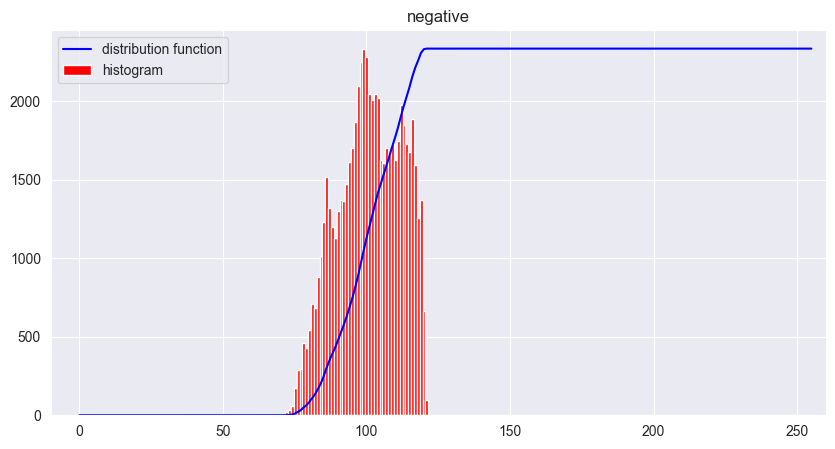

In [21]:
plot_hist(mean_negative_image, plot_title="negative", plot_cdf=True)

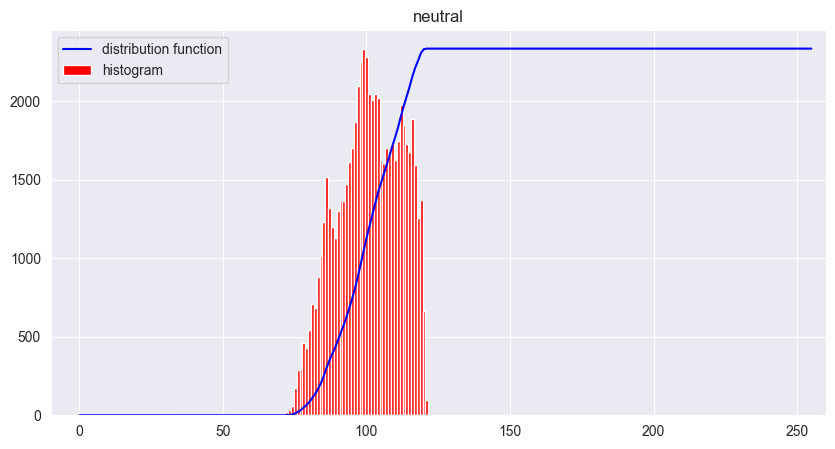

In [22]:
plot_hist(mean_neutral_image, plot_title="neutral", plot_cdf=True)

### Normalize image

In [23]:
def normalize_image(image: np.ndarray) -> np.ndarray:
    normalized_image = np.zeros_like(image)
    normalized_image = cv2.normalize(image,  normalized_image, 0, 255, cv2.NORM_MINMAX)
    return normalized_image

In [24]:
normalized_images = [normalize_image(image) for image in tqdm(resized_images)]
image_data_df["image"] = normalized_images

100%|██████████| 3255/3255 [00:00<00:00, 7706.82it/s]


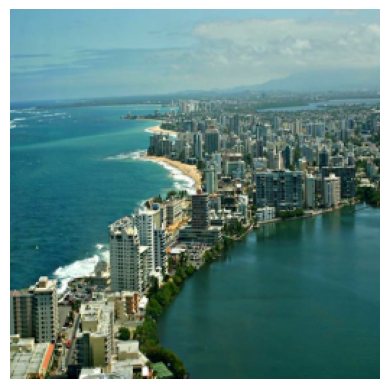

In [25]:
plot_image(resized_images[10])

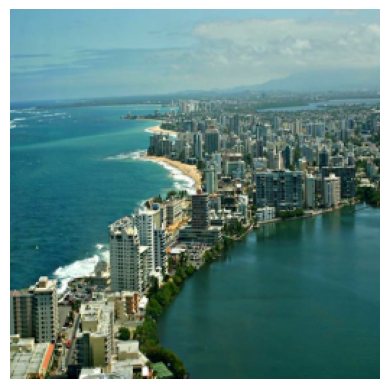

In [26]:
plot_image(normalized_images[10])

### Image equalization

In [27]:
def image_equalization(image: np.ndarray) -> np.ndarray:
    clache = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    ycrcb_img = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    ycrcb_img[:, :, 0] = clache.apply(ycrcb_img[:, :, 0])
    equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
    return equalized_img

In [28]:
equalization_images = [image_equalization(image) for image in tqdm(normalized_images)]
image_data_df["image"] = equalization_images

100%|██████████| 3255/3255 [00:01<00:00, 1658.56it/s]


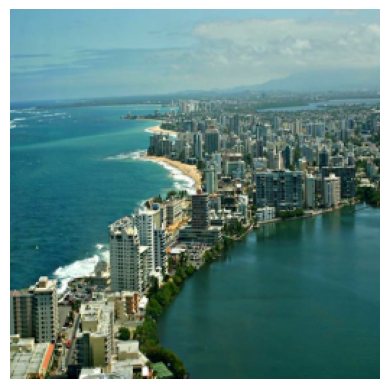

In [29]:
plot_image(resized_images[10])

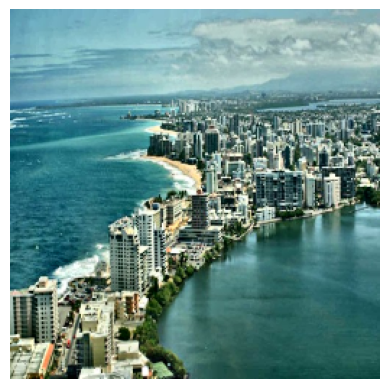

In [30]:
plot_image(equalization_images[10])

## Store dataset

In [31]:
image_data_df.columns

Index(['file', 'width', 'height', 'colors', 'file_format', 'sentiment',
       'source_image', 'image'],
      dtype='object')

In [32]:
PREPROCESS_DIR = "./data/preprocess_images"
if not os.path.exists(PREPROCESS_DIR):
    os.makedirs(PREPROCESS_DIR)
    print("Preprocess data directory was created")

preprocess_path = Path(PREPROCESS_DIR)
image_data = {"image_path": [], "sentiment": []}
for index, row in tqdm(image_data_df.iterrows(), total=image_data_df.shape[0]):
    image = row["image"]
    file_name = f"{row['file']}{row['file_format']}"
    sentiment_dir = preprocess_path / row["sentiment"]
    if not os.path.exists(sentiment_dir):
        os.makedirs(sentiment_dir)
    image_path = Path(sentiment_dir / file_name).as_posix()
    image_data["image_path"].append(image_path)
    image_data["sentiment"].append(row["sentiment"])
    cv2.imwrite(image_path, image)

Preprocess data directory was created


100%|██████████| 3255/3255 [00:09<00:00, 345.45it/s]


In [33]:
image_data_info_df = pd.DataFrame(data=image_data)
image_data_info_df.to_csv("image_sentiment_data.csv", index=False)

## Extracting SIFT-features

In [54]:
def compute_sift_key_points(image: np.ndarray) -> tuple:
    image_ = np.copy(image)
    if len(image_.shape) == 3:
        gray = cv2.cvtColor(image_, cv2.COLOR_BGR2GRAY)
    else:
        gray= image_
    sift_descriptor = cv2.SIFT_create()
    kp, desc = sift_descriptor.detectAndCompute(gray, None)
    return kp, desc, gray

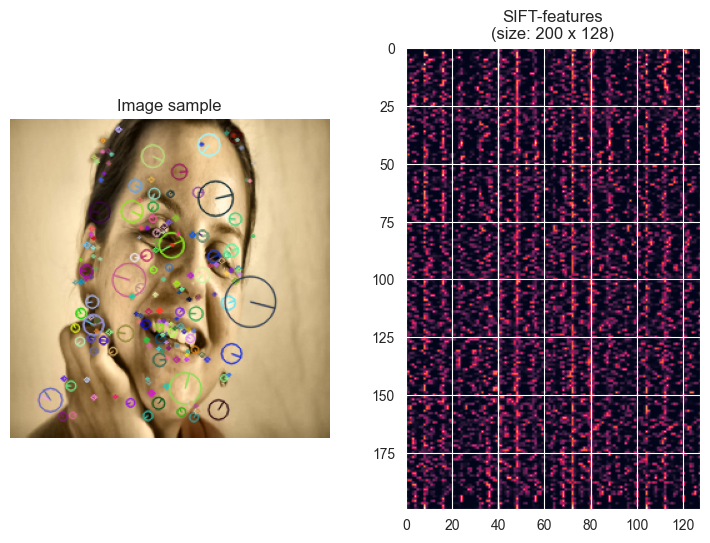

In [55]:
sample_image = equalization_images[0]
sample_kp, sample_desc, sample_gray = compute_sift_key_points(sample_image)

fig=plt.figure(figsize=(14,6))
fig.add_subplot(1,3,1)
plt.title("Image sample")
plot_image(
    cv2.drawKeypoints(
        sample_image,
        sample_kp,
        sample_gray.copy(),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
    )
)
plt.axis('off')
fig.add_subplot(1,3,2)
plt.title(f"SIFT-features\n(size: {sample_desc.shape[0]} x {sample_desc.shape[1]})")
plt.imshow(sample_desc)

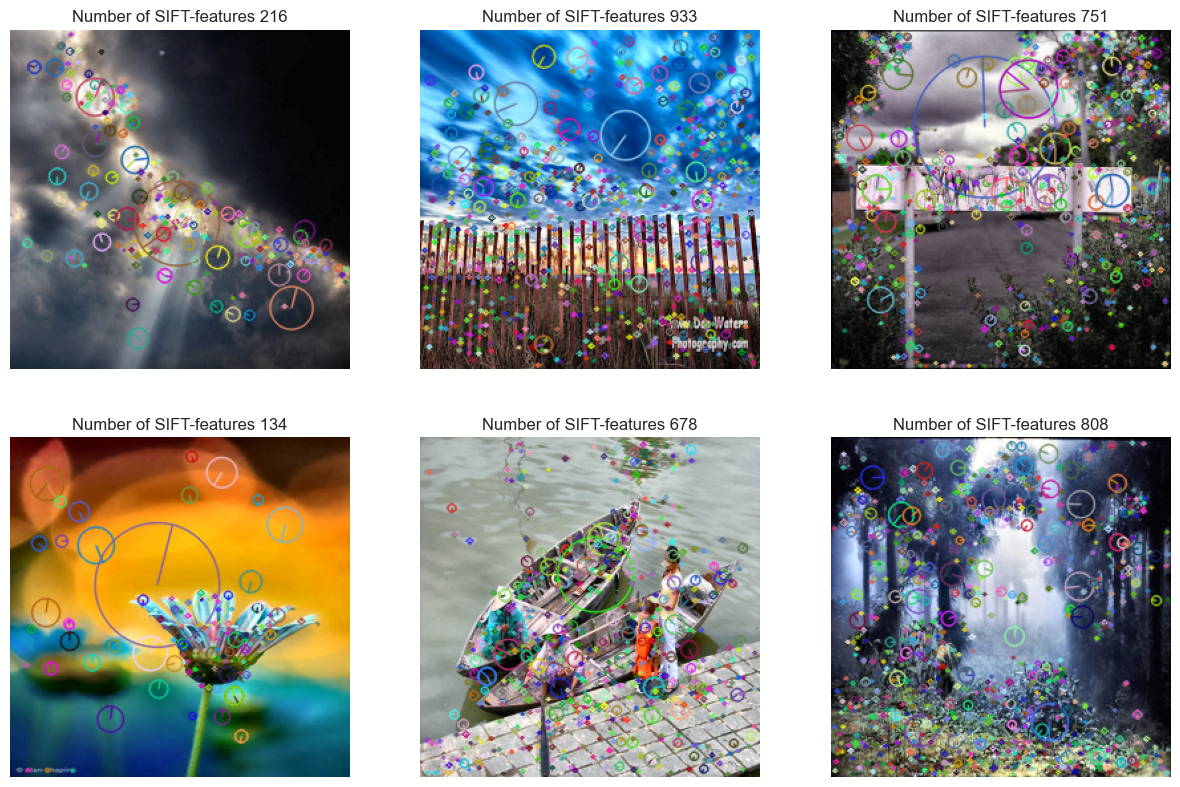

In [56]:
plt.figure(figsize = (15, 15))

N_SIFT = 6

image_indices = np.array(range(len(equalization_images)))
random_image_indices = np.random.choice(image_indices, N_SIFT, replace=False)
for i, sample_index in enumerate(random_image_indices):
    sample = equalization_images[sample_index]
    key_points, desc, gray_image = compute_sift_key_points(sample)
    plt.subplot(N_SIFT // 2, N_SIFT // 2, i + 1)
    plt.title(f"Number of SIFT-features {desc.shape[0]}")
    sift_image = cv2.drawKeypoints(sample, key_points, sample.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(cv2.cvtColor(sift_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

## Image Clustering analysis

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Histogram-based

In [58]:
image_data_df["hist"] = image_data_df["image"].progress_apply(lambda x: np.histogram(x.flatten(), 256, [0, 255])[0])

  0%|          | 0/3994 [00:00<?, ?it/s]

In [59]:
hists = np.array(image_data_df["hist"].tolist())
hists.shape

(3994, 256)

100%|██████████| 79/79 [02:34<00:00,  1.96s/it]


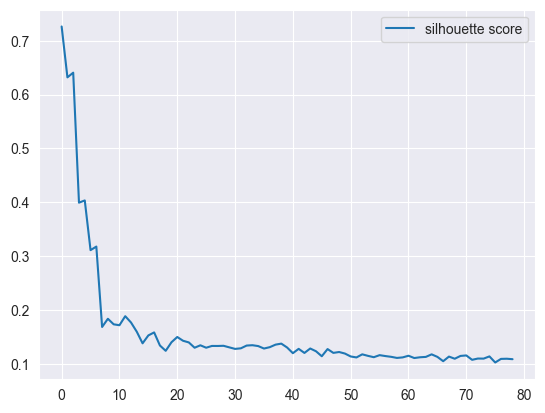

In [60]:
hists_silhouette_scores = []
for n_cluster in tqdm(range(2, 81)):
    k_means = KMeans(n_clusters=n_cluster)
    k_means.fit(hists)
    hists_silhouette_scores.append(silhouette_score(hists, k_means.labels_))

plt.plot(hists_silhouette_scores, label="silhouette score")
plt.legend()